Problem 1

🧩 Step 1 — Imports and global config

In [2]:
import os, json, random, math, time
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
import torchvision.models as models
from tqdm import tqdm

# reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

DATA_DIR = Path('data/VOC2012_train_val/VOC2012_train_val')
IMG_DIR = DATA_DIR/'JPEGImages'
ANN_DIR = DATA_DIR/'Annotations'
OUT_DIR = Path('outputs'); OUT_DIR.mkdir(parents=True, exist_ok=True)

VOC_CLASSES = ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair',
               'cow','diningtable','dog','horse','motorbike','person','pottedplant',
               'sheep','sofa','train','tvmonitor']
CLS2ID = {c:i for i,c in enumerate(VOC_CLASSES)}
ID2CLS = {i:c for c,i in CLS2ID.items()}

def imshow(img, title=None):
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    if title: plt.title(title)
    plt.axis('off'); plt.show()


Device: cpu


🧩 Step 2 — Scan and split dataset 4:1

In [3]:
all_imgs = sorted([p.stem for p in IMG_DIR.glob('*.jpg')])
print('Total images:', len(all_imgs))
assert len(all_imgs) > 0, "Check that data/VOC2012/JPEGImages exists!"

random.shuffle(all_imgs)
split = int(0.8*len(all_imgs))
train_ids, val_ids = all_imgs[:split], all_imgs[split:]
print('Train:', len(train_ids), 'Val:', len(val_ids))
print('Example IDs:', train_ids[:5])

with open(OUT_DIR/'splits.json','w') as f:
    json.dump({'train': train_ids, 'val': val_ids}, f, indent=2)

Total images: 17125
Train: 13700 Val: 3425
Example IDs: ['2008_002408', '2010_004002', '2010_006776', '2008_001946', '2011_000631']


🧩 Step 3 — Parse XML annotations + visualize boxes (Section 1.1)

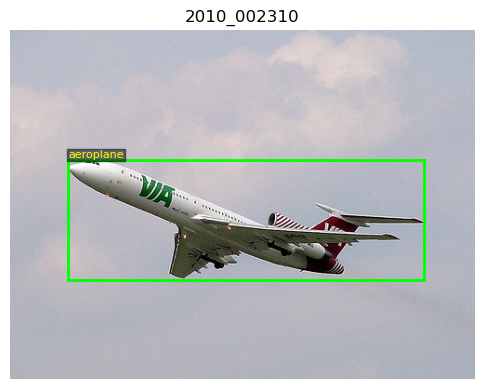

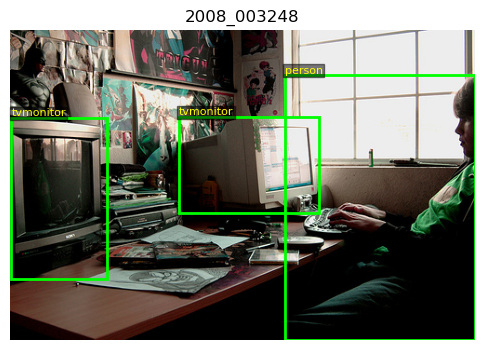

In [4]:
import xml.etree.ElementTree as ET

def parse_voc_xml(xml_path: str) -> np.ndarray:
    """Return array (N,5): [class_id,x,y,w,h] with top-left coords."""
    root = ET.parse(xml_path).getroot()
    size = root.find('size')
    W = int(size.find('width').text)
    H = int(size.find('height').text)
    objs = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        if name not in CLS2ID: continue
        cls_id = CLS2ID[name]
        bnd = obj.find('bndbox')
        xmin = int(float(bnd.find('xmin').text))
        ymin = int(float(bnd.find('ymin').text))
        xmax = int(float(bnd.find('xmax').text))
        ymax = int(float(bnd.find('ymax').text))
        x, y = xmin, ymin
        w, h = xmax - xmin, ymax - ymin
        x = max(0, min(x, W-1)); y = max(0, min(y, H-1))
        w = max(1, min(w, W-x)); h = max(1, min(h, H-y))
        objs.append([cls_id, x, y, w, h])
    return np.array(objs, dtype=np.float32)

def vis_bboxes(img_path, boxes, title='bboxes'):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6)); plt.imshow(img); ax = plt.gca()
    for cls_id, x, y, w, h in boxes:
        rect = plt.Rectangle((x,y), w, h, fill=False, linewidth=2, edgecolor='lime')
        ax.add_patch(rect)
        ax.text(x, y-2, ID2CLS[int(cls_id)], fontsize=8, color='yellow',
                bbox=dict(facecolor='black', alpha=0.5, pad=1))
    plt.title(title); plt.axis('off'); plt.show()

# test on 2 random images
for img_id in random.sample(train_ids, k=min(2, len(train_ids))):
    boxes = parse_voc_xml(str(ANN_DIR/f'{img_id}.xml'))
    vis_bboxes(str(IMG_DIR/f'{img_id}.jpg'), boxes, title=img_id)

🧩 Step 4 — Multi-label classification (Section 1.2)

In [5]:
def multi_hot_from_boxes(boxes, num_classes=len(VOC_CLASSES)):
    y = torch.zeros(num_classes, dtype=torch.float32)
    for cls_id in boxes[:,0].astype(int):
        y[cls_id] = 1.0
    return y

class VOCDatasetMultiLabel(Dataset):
    def __init__(self, images_dir, ann_dir, ids, img_size=224):
        self.images_dir, self.ann_dir, self.ids, self.img_size = Path(images_dir), Path(ann_dir), ids, img_size
    def __len__(self): return len(self.ids)
    def __getitem__(self, i):
        img_id = self.ids[i]
        img = cv2.cvtColor(cv2.imread(str(self.images_dir/f'{img_id}.jpg')), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img_t = torch.from_numpy(img).permute(2,0,1).float()/255.0
        boxes = parse_voc_xml(str(self.ann_dir/f'{img_id}.xml'))
        y = multi_hot_from_boxes(boxes)
        return img_t, y

train_dl = DataLoader(VOCDatasetMultiLabel(IMG_DIR, ANN_DIR, train_ids), batch_size=32, shuffle=True)
val_dl   = DataLoader(VOCDatasetMultiLabel(IMG_DIR, ANN_DIR, val_ids),   batch_size=32)

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, len(VOC_CLASSES))
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
opt = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

@torch.no_grad()
def val_loss():
    model.eval(); total=0; n=0
    for x,y in val_dl:
        x,y = x.to(device), y.to(device)
        loss = criterion(model(x), y)
        total += loss.item()*x.size(0); n += x.size(0)
    return total/n

for epoch in range(5):
    model.train()
    for x,y in tqdm(train_dl, desc=f'Epoch {epoch+1}/5'):
        x,y = x.to(device), y.to(device)
        loss = criterion(model(x), y)
        opt.zero_grad(); loss.backward(); opt.step()
    print('Val loss:', val_loss())

# sanity-check predictions
model.eval()
x,_ = next(iter(val_dl))
probs = torch.sigmoid(model(x.to(device))).cpu()
for i in range(3):
    top = probs[i].topk(5)
    print('Top-5:', [(VOC_CLASSES[j], float(probs[i,j])) for j in top.indices])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/mao/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 23.2MB/s]
Epoch 1/5: 100%|██████████| 429/429 [18:20<00:00,  2.57s/it]


Val loss: 0.09181574722819955


Epoch 2/5: 100%|██████████| 429/429 [18:14<00:00,  2.55s/it]


Val loss: 0.1061059799385223


Epoch 3/5: 100%|██████████| 429/429 [18:30<00:00,  2.59s/it]


Val loss: 0.10468317866542913


Epoch 4/5: 100%|██████████| 429/429 [18:30<00:00,  2.59s/it]


Val loss: 0.12072101441123624


Epoch 5/5: 100%|██████████| 429/429 [18:46<00:00,  2.63s/it]


Val loss: 0.11831815998484618
Top-5: [('person', 0.9975457787513733), ('dog', 0.024537600576877594), ('boat', 0.006270523648709059), ('bird', 0.0015130284009501338), ('cow', 0.0008045005961321294)]
Top-5: [('person', 0.9912954568862915), ('cow', 0.8239200115203857), ('bottle', 0.022963382303714752), ('tvmonitor', 0.018456079065799713), ('dog', 0.009603936225175858)]
Top-5: [('person', 0.9995710253715515), ('horse', 0.16425098478794098), ('cow', 0.0056519890204072), ('dog', 0.005258279852569103), ('car', 0.004562233574688435)]


🧩 Step 5 — RPN from scratch (Section 1.3)

In [7]:
torch.save(model.state_dict(), "outputs/resnet18_multilabel.pth")
print("✅ Saved trained ResNet-18 model to outputs/resnet18_multilabel.pth")

✅ Saved trained ResNet-18 model to outputs/resnet18_multilabel.pth


In [23]:
import torch.nn as nn
import torchvision.models as models

# 1) Recreate the same architecture from 1.2
resnet = models.resnet18(weights=None)
resnet.fc = nn.Linear(resnet.fc.in_features, len(VOC_CLASSES))

# 2) Load your fine-tuned weights from 1.2
ckpt_path = "outputs/resnet18_multilabel.pth"
resnet.load_state_dict(torch.load(ckpt_path, map_location=device))
resnet = resnet.to(device).eval()
print("Loaded:", ckpt_path)

# 3) Use only the convolutional backbone (drop avgpool & fc)
backbone_cnn = nn.Sequential(*list(resnet.children())[:-2]).to(device).eval()

# ResNet18 feature stride (pixels per feature step)
FEATURE_STRIDE = 32

Loaded: outputs/resnet18_multilabel.pth


In [24]:
def load_image_tensor(img_id: str, max_side=800):
    """Read RGB image, resize so max(H,W)=max_side, return tensor [C,H,W] in [0,1] + scale."""
    import cv2, numpy as np
    img = cv2.cvtColor(cv2.imread(str(IMG_DIR/f"{img_id}.jpg")), cv2.COLOR_BGR2RGB)
    H0, W0 = img.shape[:2]
    scale = max_side / max(H0, W0)
    if scale != 1.0:
        img = cv2.resize(img, (int(W0*scale), int(H0*scale)))
    img_t = torch.from_numpy(img).permute(2,0,1).float().to(device) / 255.0
    return img_t, scale

def scale_xywh(boxes_np, scale: float):
    """Scale VOC boxes [cls,x,y,w,h] by 'scale' (for resized images)."""
    b = boxes_np.copy()
    b[:,1:] *= scale
    return b

In [25]:
import math, torch

def generate_anchors(base_size=16, ratios=(0.5,1.0,2.0), scales=(8,16,32)):
    """Anchors centered at (0,0) in xywh (top-left + width/height) form."""
    anchors = []
    for s in scales:
        for r in ratios:
            area = (base_size * s) ** 2
            w = int(round(math.sqrt(area / r)))
            h = int(round(w * r))
            x = -w // 2; y = -h // 2
            anchors.append([x, y, w, h])
    return torch.tensor(anchors, dtype=torch.float32)

def shift_anchors_v2(feat_h, feat_w, stride, base_anchors):
    """
    Generate anchors across the feature map grid.
    Returns (feat_h * feat_w * A, 4) in xywh (top-left + w,h).
    """
    device = base_anchors.device
    A = base_anchors.size(0)

    # grid of shifts (in pixels)
    xs = torch.arange(feat_w, device=device) * stride
    ys = torch.arange(feat_h, device=device) * stride
    yy, xx = torch.meshgrid(ys, xs, indexing='ij')       # (Hf,Wf)

    # flatten to (K,2)
    shifts = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=1)  # (K,2)
    K = shifts.size(0)

    # expand to (K, A, 4) and (K, A, 2)
    base = base_anchors.view(1, A, 4).expand(K, A, 4).clone()     # (K,A,4)
    shift = shifts.view(K, 1, 2).expand(K, A, 2).clone()          # (K,A,2)

    # top-left xy + keep w,h
    base[..., 0] = base[..., 0] + shift[..., 0]   # x
    base[..., 1] = base[..., 1] + shift[..., 1]   # y

    return base.reshape(-1, 4)                     # (K*A, 4)

def bbox_iou_xywh(a, b):
    """Pairwise IoU between sets of boxes in xywh (top-left) format."""
    a_x1, a_y1 = a[:,0], a[:,1]; a_x2 = a_x1 + a[:,2]; a_y2 = a_y1 + a[:,3]
    b_x1, b_y1 = b[:,0], b[:,1]; b_x2 = b_x1 + b[:,2]; b_y2 = b_y1 + b[:,3]
    inter_x1 = torch.max(a_x1[:,None], b_x1[None,:])
    inter_y1 = torch.max(a_y1[:,None], b_y1[None,:])
    inter_x2 = torch.min(a_x2[:,None], b_x2[None,:])
    inter_y2 = torch.min(a_y2[:,None], b_y2[None,:])
    inter = (inter_x2 - inter_x1).clamp(min=0) * (inter_y2 - inter_y1).clamp(min=0)
    area_a = (a_x2 - a_x1).clamp(min=0) * (a_y2 - a_y1).clamp(min=0)
    area_b = (b_x2 - b_x1).clamp(min=0) * (b_y2 - b_y1).clamp(min=0)
    return inter / (area_a[:,None] + area_b[None,:] - inter + 1e-6)

def encode_deltas(anchors, gt):
    """RPN box regression targets (tx,ty,tw,th)."""
    ax, ay, aw, ah = anchors.T
    gx, gy, gw, gh = gt.T
    tx = (gx - ax) / aw.clamp(min=1.0)
    ty = (gy - ay) / ah.clamp(min=1.0)
    tw = torch.log(gw / aw.clamp(min=1.0))
    th = torch.log(gh / ah.clamp(min=1.0))
    return torch.stack([tx, ty, tw, th], dim=-1)

def decode_deltas(anchors, deltas):
    """Invert encoding to get boxes in xywh."""
    ax, ay, aw, ah = anchors.T
    tx, ty, tw, th = deltas.T
    gx = ax + tx * aw
    gy = ay + ty * ah
    gw = aw * torch.exp(tw.clamp(-10, 10))
    gh = ah * torch.exp(th.clamp(-10, 10))
    return torch.stack([gx, gy, gw, gh], dim=-1)

def nms_xywh(boxes, scores, iou_thr=0.7, topk=1000):
    """Simple NMS for xywh; returns kept indices."""
    if boxes.numel() == 0:
        return torch.empty(0, dtype=torch.long)
    b = boxes.clone()
    b[:,2] = b[:,0] + b[:,2]
    b[:,3] = b[:,1] + b[:,3]  # to xyxy
    order = scores.sort(descending=True).indices[:topk]
    keep = []
    while order.numel() > 0:
        i = order[0].item()
        keep.append(i)
        if order.numel() == 1: break
        rest = order[1:]
        xx1 = torch.maximum(b[i,0], b[rest,0])
        yy1 = torch.maximum(b[i,1], b[rest,1])
        xx2 = torch.minimum(b[i,2], b[rest,2])
        yy2 = torch.minimum(b[i,3], b[rest,3])
        inter = (xx2-xx1).clamp(min=0) * (yy2-yy1).clamp(min=0)
        area_i = (b[i,2]-b[i,0]) * (b[i,3]-b[i,1])
        area_r = (b[rest,2]-b[rest,0]) * (b[rest,3]-b[rest,1])
        iou = inter / (area_i + area_r - inter + 1e-6)
        order = rest[iou <= iou_thr]
    return torch.tensor(keep, dtype=torch.long)

In [26]:
class RPNHead(nn.Module):
    """3×3 conv → two 1×1 heads (objectness, bbox deltas)."""
    def __init__(self, in_ch, num_anchors):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, 256, 3, padding=1)
        self.obj  = nn.Conv2d(256, num_anchors * 1, 1)
        self.reg  = nn.Conv2d(256, num_anchors * 4, 1)
    def forward(self, feat):
        t = F.relu(self.conv(feat))
        return self.obj(t), self.reg(t)

base_anchors = generate_anchors(base_size=16, ratios=(0.5,1.0,2.0), scales=(8,16,32)).to(device)
A = base_anchors.shape[0]  # 9 anchors per location
rpn = RPNHead(in_ch=512, num_anchors=A).to(device)

rpn_opt = torch.optim.AdamW(rpn.parameters(), lr=1e-3, weight_decay=1e-4)
pos_iou_thr, neg_iou_thr = 0.7, 0.3
samples_per_img = 256
lambda_reg = 1.0  # weight for bbox loss

In [27]:
from tqdm import tqdm

def single_image_targets(img_id, feat, anchors):
    """Compute objectness labels and bbox targets for one image."""
    gt_np = parse_voc_xml(str(ANN_DIR / f"{img_id}.xml"))
    if gt_np.size == 0:
        return None  # skip images without objects
    img_t, scale = load_image_tensor(img_id)  # only for size; we already have feat
    gt_np_scaled = scale_xywh(gt_np, scale)
    gt_xywh = torch.tensor(gt_np_scaled[:,1:], dtype=torch.float32, device=device)

    ious = bbox_iou_xywh(anchors, gt_xywh)
    iou_max, iou_arg = ious.max(dim=1)

    labels = torch.full((anchors.shape[0],), -1, dtype=torch.int64, device=device)  # -1 ignore
    labels[iou_max >= pos_iou_thr] = 1
    labels[iou_max <= neg_iou_thr] = 0

    # Ensure each GT has at least one positive (best-matching anchor)
    gt_best, gt_best_idx = ious.max(dim=0)
    labels[gt_best_idx] = 1

    pos_idx = torch.where(labels == 1)[0]
    if pos_idx.numel() == 0:
        return None
    reg_t = encode_deltas(anchors[pos_idx], gt_xywh[iou_arg[pos_idx]])
    return labels, pos_idx, reg_t

def image_to_feat_and_anchors(img_id, max_side=800):
    img_t, scale = load_image_tensor(img_id, max_side=max_side)
    with torch.no_grad():
        feat = backbone_cnn(img_t.unsqueeze(0))                # (1,512,Hf,Wf)
    _,_,Hf,Wf = feat.shape
    anchors = shift_anchors_v2(Hf, Wf, FEATURE_STRIDE, base_anchors).to(device)
    return img_t, feat, anchors, scale

# ---- training loop (small demo: 2 epochs × 200 images). Increase for better quality.
RPN_EPOCHS = 2
for ep in range(1, RPN_EPOCHS+1):
    ids = random.sample(train_ids, k=min(200, len(train_ids)))
    pbar = tqdm(ids, desc=f'RPN Epoch {ep}/{RPN_EPOCHS}')
    running_obj, running_reg, n = 0.0, 0.0, 0
    for img_id in pbar:
        img_t, feat, anchors, _ = image_to_feat_and_anchors(img_id, max_side=800)

        obj_logits, reg_deltas = rpn(feat)
        obj_logits = obj_logits.permute(0,2,3,1).reshape(-1)    # (Nanchors,)
        reg_deltas = reg_deltas.permute(0,2,3,1).reshape(-1,4)  # (Nanchors,4)

        # targets
        targets = single_image_targets(img_id, feat, anchors)
        if targets is None:
            continue
        labels, pos_idx, reg_t = targets

        # sample a balanced mini-batch of anchors (pos:neg ≈ 1:1)
        num_pos = min(int(samples_per_img*0.5), pos_idx.numel())
        perm_pos = pos_idx[torch.randperm(pos_idx.numel())[:num_pos]]
        neg_idx = torch.where(labels==0)[0]
        num_neg = min(samples_per_img - num_pos, neg_idx.numel())
        perm_neg = neg_idx[torch.randperm(neg_idx.numel())[:num_neg]]
        keep = torch.cat([perm_pos, perm_neg])

        # losses
        obj_target = torch.zeros_like(obj_logits)
        obj_target[perm_pos] = 1.0
        obj_loss = F.binary_cross_entropy_with_logits(obj_logits[keep], obj_target[keep])

        reg_pred = reg_deltas[perm_pos]
        reg_loss = F.smooth_l1_loss(reg_pred, reg_t, reduction='mean')

        loss = obj_loss + lambda_reg * reg_loss
        rpn_opt.zero_grad(); loss.backward(); rpn_opt.step()

        running_obj += float(obj_loss); running_reg += float(reg_loss); n += 1
        pbar.set_postfix({'obj': f'{running_obj/max(1,n):.3f}', 'reg': f'{running_reg/max(1,n):.3f}'})

print("✅ RPN training finished.")

RPN Epoch 2/2: 100%|██████████| 200/200 [00:43<00:00,  4.57it/s, obj=0.112, reg=0.065]

✅ RPN training finished.


In [37]:
@torch.no_grad()
def visualize_rpn(img_id, nms_thr=0.4, score_thr=0.5, topk_before=500, keep_after=50, max_side=800):
    """Plot GT (green) and RPN proposals (red) for one image."""
    import matplotlib.pyplot as plt

    img_t, feat, anchors, scale = image_to_feat_and_anchors(img_id, max_side=max_side)
    obj_logits, reg_deltas = rpn(feat)
    obj_logits = obj_logits.permute(0,2,3,1).reshape(-1)
    reg_deltas = reg_deltas.permute(0,2,3,1).reshape(-1,4)

    # Get proposal boxes and scores
    scores = torch.sigmoid(obj_logits)
    keep_high = (scores > score_thr).nonzero(as_tuple=True)[0]
    scores = scores[keep_high]
    anchors_sel = anchors[keep_high]
    deltas_sel = reg_deltas[keep_high]
    props = decode_deltas(anchors_sel, deltas_sel)

    # clip to image bounds
    H, W = img_t.shape[1:]
    props[:,0] = props[:,0].clamp(0, W-1)
    props[:,1] = props[:,1].clamp(0, H-1)
    props[:,2] = props[:,2].clamp(min=1)
    props[:,3] = props[:,3].clamp(min=1)

    # Apply NMS
    keep = nms_xywh(props, scores, iou_thr=nms_thr, topk=topk_before)
    props = props[keep][:keep_after].cpu()
    scores = scores[keep][:keep_after].cpu()

    # Load ground-truth boxes
    gt = parse_voc_xml(str(ANN_DIR/f"{img_id}.xml"))
    if gt.size > 0:
        gt[:,1:] *= scale

    # Visualization
    img = img_t.cpu().permute(1,2,0).numpy()
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    ax = plt.gca(); ax.axis("off")
    plt.title(f"{img_id}: Green=GT, Red=Proposals")

    # GT (green)
    for b in gt[:,1:]:
        x,y,w,h = b
        ax.add_patch(plt.Rectangle((x,y), w,h, fill=False, edgecolor='g', linewidth=2))

    # Proposals (red)
    for b,s in zip(props, scores):
        x,y,w,h = b
        ax.add_patch(plt.Rectangle((x,y), w,h, fill=False, edgecolor='r', linewidth=1))
    plt.show()

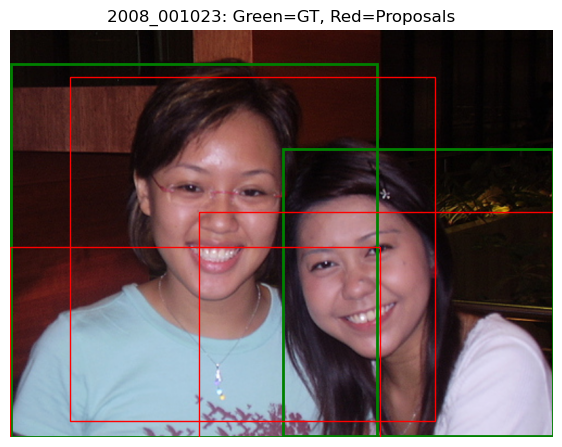

In [39]:
visualize_rpn("2008_001023", nms_thr=0.3, score_thr=0.3, keep_after=30)

Problem 2

Step 1. Install the corruption library

In [41]:
pip install imagecorruptions

Note: you may need to restart the kernel to use updated packages.


Step 2. Imports and setup

In [2]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from imagecorruptions import corrupt
import cv2, numpy as np, random, matplotlib.pyplot as plt
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


Step 3. Dataset for Noisy / Clean Pairs

In [4]:
IMG_DIR = Path("data/VOC2012_train_val/VOC2012_train_val/JPEGImages")

class DenoisingVOCDataset(Dataset):
    def __init__(self, img_ids, img_size=128, corruption_type="gaussian_noise"):
        self.img_ids = img_ids
        self.img_size = img_size
        self.corruption_type = corruption_type
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_path = IMG_DIR / f"{img_id}.jpg"
        img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size))

        clean = self.to_tensor(img).float()
        corrupted = corrupt(img, corruption_name=self.corruption_type)
        corrupted = self.to_tensor(corrupted).float()

        return corrupted, clean

Step 4. Split data and build dataloaders

In [9]:
random.seed(42)
all_ids = [p.stem for p in IMG_DIR.glob("*.jpg")]
random.shuffle(all_ids)
split = int(0.8 * len(all_ids))
train_ids, val_ids = all_ids[:split], all_ids[split:]

train_ds = DenoisingVOCDataset(train_ids, img_size=128, corruption_type="gaussian_noise")
val_ds   = DenoisingVOCDataset(val_ids, img_size=128, corruption_type="gaussian_noise")

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_dl   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)

Step 5. Define the Denoising AutoEncoder model

In [10]:
class DenoiseAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Decoder
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x

model = DenoiseAutoEncoder().to(device)
print("Model ready.")

Model ready.


Step 6. Training loop

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

def validate():
    model.eval()
    total = 0
    with torch.no_grad():
        for x_noisy, x_clean in val_dl:
            x_noisy, x_clean = x_noisy.to(device), x_clean.to(device)
            pred = model(x_noisy)
            total += criterion(pred, x_clean).item() * x_noisy.size(0)
    return total / len(val_dl.dataset)

for epoch in range(10):
    model.train()
    for x_noisy, x_clean in train_dl:
        x_noisy, x_clean = x_noisy.to(device), x_clean.to(device)
        out = model(x_noisy)
        loss = criterion(out, x_clean)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
    val_loss = validate()
    print(f"Epoch {epoch+1}/10 | Train loss: {loss.item():.4f} | Val loss: {val_loss:.4f}")

Epoch 1/10 | Train loss: 0.0111 | Val loss: 0.0103
Epoch 2/10 | Train loss: 0.0070 | Val loss: 0.0086
Epoch 3/10 | Train loss: 0.0068 | Val loss: 0.0082
Epoch 4/10 | Train loss: 0.0088 | Val loss: 0.0074
Epoch 5/10 | Train loss: 0.0093 | Val loss: 0.0071
Epoch 6/10 | Train loss: 0.0066 | Val loss: 0.0069
Epoch 7/10 | Train loss: 0.0047 | Val loss: 0.0067
Epoch 8/10 | Train loss: 0.0082 | Val loss: 0.0065
Epoch 9/10 | Train loss: 0.0064 | Val loss: 0.0065
Epoch 10/10 | Train loss: 0.0063 | Val loss: 0.0062


Step 7. Visualization — Corrupted → Restored → Original

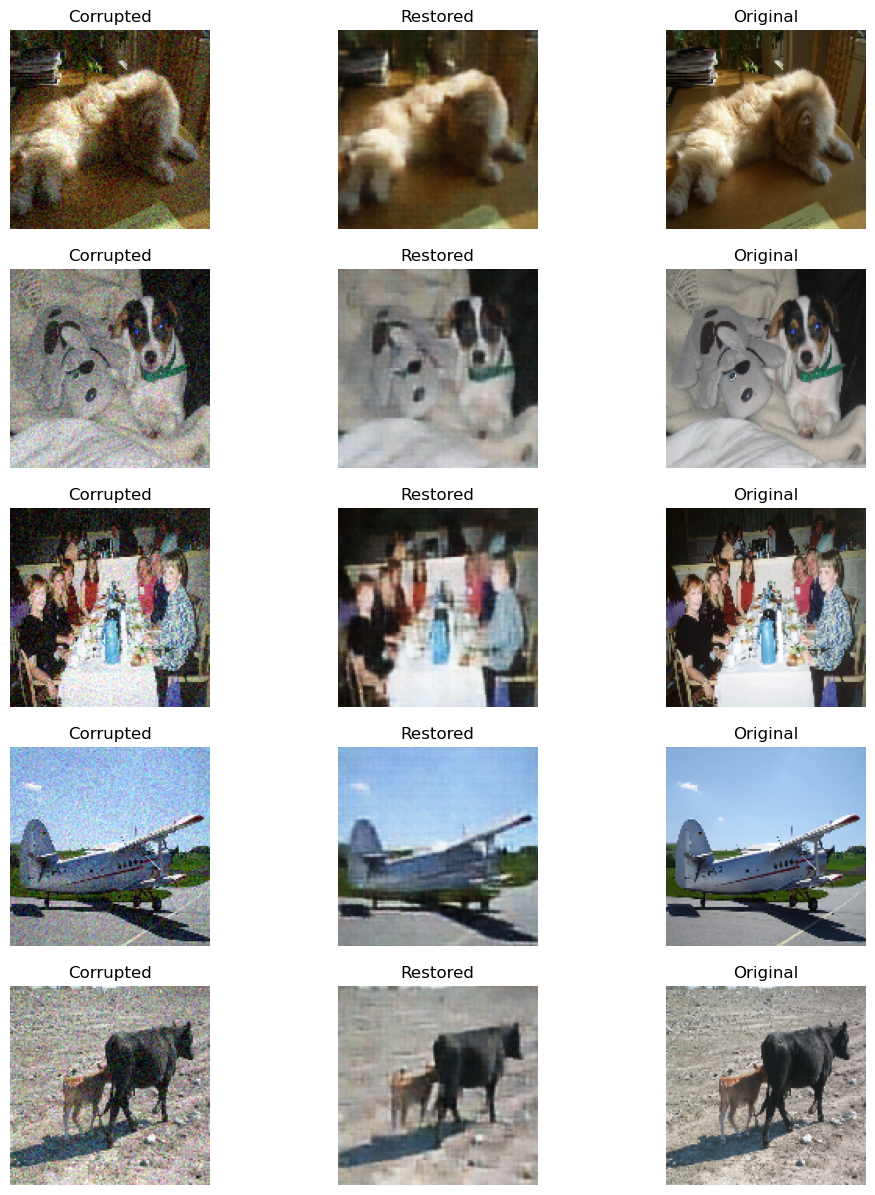

In [13]:
@torch.no_grad()
def visualize_examples(n=5):
    model.eval()
    x_noisy, x_clean = next(iter(val_dl))
    x_noisy, x_clean = x_noisy.to(device), x_clean.to(device)
    pred = model(x_noisy)

    plt.figure(figsize=(12, n*3))
    for i in range(n):
        noisy = x_noisy[i].permute(1,2,0).cpu().numpy()
        recon = pred[i].permute(1,2,0).cpu().numpy()
        clean = x_clean[i].permute(1,2,0).cpu().numpy()
        plt.subplot(n,3,3*i+1); plt.imshow(noisy); plt.axis('off'); plt.title('Corrupted')
        plt.subplot(n,3,3*i+2); plt.imshow(recon); plt.axis('off'); plt.title('Restored')
        plt.subplot(n,3,3*i+3); plt.imshow(clean); plt.axis('off'); plt.title('Original')
    plt.show()

visualize_examples(5)